In [2]:
!ls

Untitled.ipynb


## Imports

In [4]:
!pip install fastai --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 186 kB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 461 kB/s  eta 0:00:01
     |████████████████████████████████| 22.1 MB 31.7 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 1.9 kB/s  eta 0:00:01    |██                              | 51.3 MB 75.2 MB/s eta 0:00:11     |████▎                           | 109.9 MB 56.1 MB/s eta 0:00:13     |███████▎                        | 189.1 MB 32.7 MB/s eta 0:00:20     |████████▌                       | 220.3 MB 60.1 MB/s eta 0:00:11     |█████████▏                     

In [5]:
!pip install pydicom kornia opencv-python scikit-image


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 2.0 MB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 336 kB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 49.9 MB 65 kB/s s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

In [8]:
warnings.filterwarnings('ignore')

## Data Part

**First, we will use the untar_data function to download the _siimsmall folder containing a subset (250 DICOM files, ~30MB) of the SIIM-ACR Pneumothorax Segmentation [1] dataset. The downloaded _siimsmall folder will be stored in your ~/.fastai/data/ directory. The variable pneumothorax-source will store the absolute path to the _siimsmall folder as soon as the download is complete.**

* 16 bit DICOM images have values ranging from -32768 to 32768 while 8-bit greyscale images store values from 0 to 255. The value ranges in DICOM images are useful as they correlate with the Hounsfield Scale which is a quantitative scale for describing radiodensity

* Pydicom is a python package for parsing DICOM files, making it easier to access the header of the DICOM as well as coverting the raw pixel_data into pythonic structures for easier manipulation. fastai.medical.imaging uses pydicom.dcmread to load the DICOM file.

In [2]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)


In [3]:
items = get_dicom_files(pneumothorax_source/f"train/")


In [4]:
trn,val = RandomSplitter()(items)


In [5]:
patient = 7
xray_sample = items[patient].dcmread()


**Some key pointers on the tag information above:**

**Pixel Data (7fe0 0010)** - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first

**Photometric Interpretation (0028, 0004)**- also known as color space. In this case it is MONOCHROME2 where pixel data is represented as a single monochrome image plane where low values=dark, high values=bright. If the colorspace was MONOCHROME then the low values=bright and high values=dark info.

**Samples per Pixel (0028, 0002)**- This should be 1 as this image is monochrome. This value would be 3 if the color space was RGB for example

**Bits Stored (0028 0101)** - Number of bits stored for each pixel sample. Typical 8 bit images have a pixel range between 0 and 255
Pixel Represenation(0028 0103) - can either be unsigned(0) or signed(1)

**Lossy Image Compression (0028 2110)** - 00 image has not been subjected to lossy compression. 01 image has been subjected to lossy compression.

**Lossy Image Compression Method (0028 2114)** - states the type of lossy compression used (in this case ISO_10918_1 represents JPEG Lossy Compression)

**Pixel Data (7fe0, 0010)** - Array of 161452 elements represents the image pixel data that pydicom uses to convert the pixel data into an image.

In [18]:
xray_sample


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.14202.1517875250.219016
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.14202.1517875250.219016
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [9]:
dicom_dataframe = pd.DataFrame.from_dicoms(items)
dicom_dataframe[:5]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,...,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2654.1517875173.901803,19010101,000000.00,,CR,WSD,(),view: PA,...,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000185.dcm,1,0.139,0,255,157.143353,60.737689,0.087357
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.6207.1517875197.39635,19010101,000000.00,,CR,WSD,(),view: AP,...,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000068.dcm,1,0.139,0,243,89.828911,61.422476,0.333747
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.11010.1517875229.498545,19010101,000000.00,,CR,WSD,(),view: AP,...,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000086.dcm,1,0.139,0,235,102.154199,42.022871,0.308454
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.334.1517875162.431427,19010101,000000.00,,CR,WSD,(),view: AP,...,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000158.dcm,1,0.139,0,255,133.119537,54.482375,0.172193
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.4796.1517875184.852693,19010101,000000.00,,CR,WSD,(),view: AP,...,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000213.dcm,1,0.139,0,255,76.805113,49.777688,0.205881


In [10]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [38]:
df.values[:3]

array([['train/No Pneumothorax/000000.dcm', 'No Pneumothorax'],
       ['train/Pneumothorax/000001.dcm', 'Pneumothorax'],
       ['train/No Pneumothorax/000002.dcm', 'No Pneumothorax']],
      dtype=object)

In [39]:
PILDicom??

Init signature: PILDicom()
Docstring:     
This class represents an image object.  To create
:py:class:`~PIL.Image.Image` objects, use the appropriate factory
functions.  There's hardly ever any reason to call the Image constructor
directly.

* :py:func:`~PIL.Image.open`
* :py:func:`~PIL.Image.new`
* :py:func:`~PIL.Image.frombytes`
Source:        
class PILDicom(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        "Open a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`"
        if isinstance(fn,bytes): im = Image.fromarray(pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn)).pixel_array)
        if isinstance(fn,(Path,str)): im = Image.fromarray(pydicom.dcmread(fn).pixel_array)
        im.load()
        im = im._new(im.im)
        return cls(im.convert(mode) if mode else im)
File:           /opt/conda/lib/python3.7/site-packages/fastai/medical/imag

> Now, we use the DataBlock class to prepare the DICOM data for training.

As we are dealing with DICOM images, we need to use PILDicom as the ImageBlock category. This is so the DataBlock will know how to open the DICOM images. As this is a binary classification task we will use CategoryBlock

In [11]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])

dls = pneumothorax.dataloaders(df.values, num_workers=0,bs=4)

In [12]:
dls.bs

4

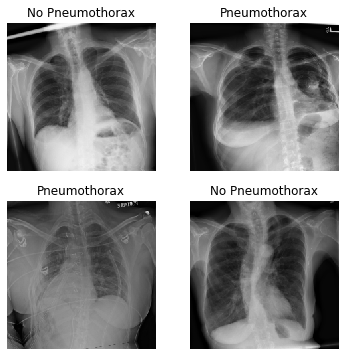

In [13]:
dls = pneumothorax.dataloaders(df.values,bs=4)
dls.show_batch(max_n=8)

## Training

In [14]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)


In [ ]:
learn.lr_find()


In [15]:
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,accuracy,time
0,1.105656,0.892013,0.700000,00:48


In [16]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")


('Pneumothorax', tensor(1), tensor([0.3318, 0.6682]))

## Results Evaluation

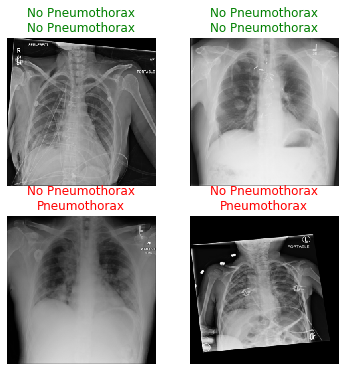

In [17]:
learn.show_results(max_n=16)


In [18]:
interp = Interpretation.from_learner(learn)


> The images, on which the learne performed worst, so we can dive deeper

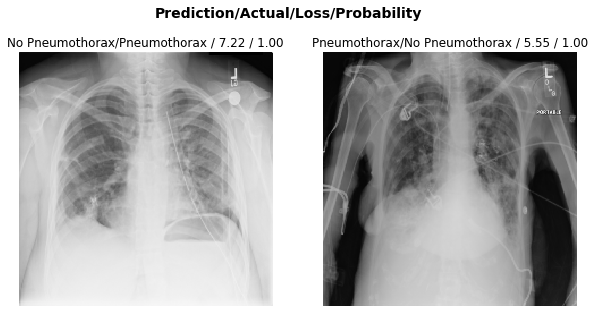

In [21]:
interp.plot_top_losses(2,figsize=(10,5))


In [23]:
class_intep=ClassificationInterpretation.from_learner(learn)

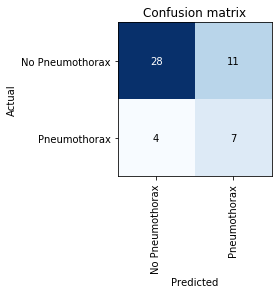

In [24]:
class_intep.plot_confusion_matrix()

In [25]:
losses,idxs = class_intep.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)


True

> There are some other key terms that need to be used when evaluating medical models:

**False Positive & False Negative**

False Positive is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present
False Negative is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present

**Sensitivity & Specificity**

Sensitivity or True Positive Rate is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives
Example: A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition

**Specificity or True Negative Rate** is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives

In [27]:
upp, low = class_intep.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

28 11 4 7


In [28]:
sensitivity = tp/(tp + fn)
sensitivity

0.6363636363636364

In [29]:
specificity = tn/(fp + tn)
specificity

0.717948717948718

**PPV and NPV**

Most medical testing is evaluated via PPV (Positive Predictive Value) or NPV (Negative Predictive Value).

PPV - if the model predicts a patient has a condition what is the probability that the patient actually has the condition

NPV - if the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

In [30]:
ppv = tp/(tp+fp)
ppv

0.3888888888888889

In [31]:
npv = tn/(tn+fn)
npv

0.875

In [33]:
val = dls.valid_ds.cat


In [34]:
len(val)

2

> Where prevalence is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time. The prevalence in this case is how many patients in the valid dataset have the condition compared to the total number.

In [35]:
prevalence = 15/50
prevalence

0.3

In [36]:
accuracy = (sensitivity * prevalence) + (specificity * (1 - prevalence))
accuracy

0.6934731934731935